In [1]:
import sys
sys.path.insert(0, '..')
from utils import load_npy_image, load_tiff_image
import os
import matplotlib.pyplot as plt
import numpy as np
from preprocess_save_patches_Amazon import mask_no_considered
from skimage.util.shape import view_as_windows
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [2]:
import random

# import cv2
from matplotlib import pyplot as plt

import albumentations as A
import tensorflow as tf

In [3]:
root_path = '/media/thimabru/ssd/TCC/imagens_satelite_dataset/cut_img_66_new'
# Load images --------------------------------------------------------------
img_t1_path = 'cut_raster_2018_ok.tif'
img_t2_path = 'cut_raster_2019_ok.tif'
img_t1 = load_tiff_image(os.path.join(root_path, img_t1_path))
print(type(img_t1))
img_t2 = load_tiff_image(os.path.join(root_path, img_t2_path))
print(img_t1.shape)
print(img_t2.shape)

/media/thimabru/ssd/TCC/imagens_satelite_dataset/cut_img_66_new/cut_raster_2018_ok.tif
<class 'numpy.ndarray'>
/media/thimabru/ssd/TCC/imagens_satelite_dataset/cut_img_66_new/cut_raster_2019_ok.tif
(7, 5222, 5043)
(7, 5222, 5043)


In [4]:
# Convert shape from C x H x W --> H x W x C
# Convert from float32 to uint8
img_t1 = img_t1.transpose((1, 2, 0))
img_t2 = img_t2.transpose((1, 2, 0))
input_image = np.concatenate((img_t1, img_t2), axis=-1)
# img_train_normalized = normalization(img_train)
print('Image 7 bands')
print(img_t1.shape)
print(img_t1.dtype)
print(img_t2.shape)
print(img_t2.dtype)
print(input_image.shape)
print(input_image.dtype)
print(img_t1.min(), img_t1.max())

Image 7 bands
(5222, 5043, 7)
uint16
(5222, 5043, 7)
uint16
(5222, 5043, 14)
uint16
4058 65535


In [5]:
img_t1_bgr = (img_t1[:, :, 1:4]).astype(np.uint8)
img_t1_rgb = img_t1_bgr[:, :, ::-1]
print(img_t1_rgb.min(), img_t1_rgb.max())

0 255


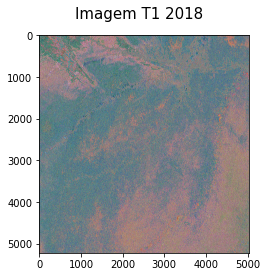

In [6]:
fig = plt.figure()
fig.suptitle('Imagem T1 2018', fontsize=15)
plt.imshow(img_t1_bgr)
fig.savefig('/media/thimabru/ssd/TCC/cut_img_t1_rgb_new.jpg', dpi=300)

In [7]:
array_sum = np.sum(img_t1_rgb)
array_has_nan = np.isnan(array_sum)

print(array_has_nan)

False


In [8]:
img_t2_bgr = img_t2[:, :, 1:4].astype(np.uint8)
img_t2_rgb = img_t2_bgr[:, :, ::-1]
print(img_t2_rgb.min(), img_t2_rgb.max())

0 255


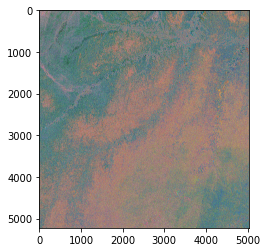

In [9]:
plt.imshow(img_t2_bgr)

In [10]:
'''
    0 --> No deforastation
    1 --> Deforastation
'''
image_ref = load_tiff_image(os.path.join(root_path,
                                        'cut_ref_2019_ok.tif'))
# Clip to fit tiles of your specific image
# image_ref = image_ref[:6100, :6600]
# image_ref[img_mask_ref == -99] = -1
print(f"Image reference shape: {image_ref.shape}")

# count_deforastation(image_ref, img_mask_ref)

/media/thimabru/ssd/TCC/imagens_satelite_dataset/cut_img_66_new/cut_ref_2019_ok.tif
Image reference shape: (5222, 5043)


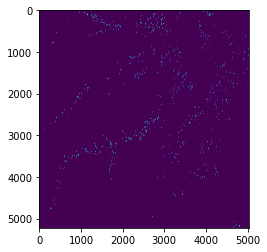

In [11]:
plt.imshow(image_ref)

In [12]:
past_ref1 = load_tiff_image(os.path.join(root_path,
                                        'cut_ref_2008_2018_ok.tif'))
past_ref2 = load_tiff_image(os.path.join(root_path,
                                        'cut_ref_1988_2007_ok.tif'))
past_ref_sum = past_ref1 + past_ref2
# Clip to fit tiles of your specific image
# past_ref_sum = past_ref_sum[:6100, :6600]
# past_ref_sum[img_mask_ref==-99] = -1
# Doing the sum, there are some pixels with value 2 (Case when both were deforastation).
# past_ref_sum[past_ref_sum == 2] = 1
# Same thing for background area (different from no deforastation)
# past_ref_sum[past_ref_sum==-2] = -1
print(f"Past reference shape: {past_ref_sum.shape}")

/media/thimabru/ssd/TCC/imagens_satelite_dataset/cut_img_66_new/cut_ref_2008_2018_ok.tif
/media/thimabru/ssd/TCC/imagens_satelite_dataset/cut_img_66_new/cut_ref_1988_2007_ok.tif
Past reference shape: (5222, 5043)


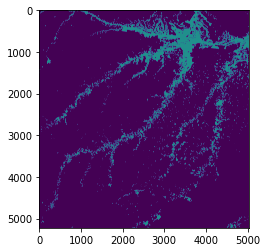

In [13]:
plt.imshow(past_ref_sum)

In [14]:
buffer = 2
final_mask = mask_no_considered(image_ref, buffer, past_ref_sum)
print(final_mask.shape)
print(final_mask.dtype)
final_mask = final_mask.astype(np.uint8)

(5222, 5043)
float32


In [15]:
del image_ref, past_ref_sum

In [16]:
import matplotlib.patches as mpatches

[0 1 2]


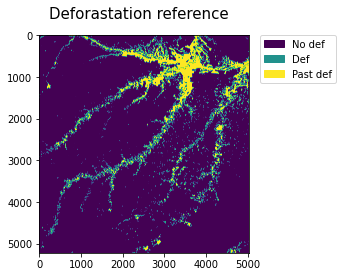

In [17]:
fig = plt.figure()
fig.suptitle('Deforastation reference', fontsize=15)
im = plt.imshow(final_mask)

values, counts = np.unique(final_mask, return_counts=True)
print(values)
values_name = ['No def', 'Def', 'Past def']
# counts_dict = dict(zip(unique, counts))
# print(f'Class pixels of final mask: {counts_dict}')

# get the colors of the values, according to the 
# colormap used by imshow
colors = [ im.cmap(im.norm(value)) for value in values]
# create a patch (proxy artist) for every color 
patches = [ mpatches.Patch(color=colors[i], label=f"{values_name[i]}" ) for i in range(len(values)) ]
# put those patched as legend-handles into the legend
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )

# fig.savefig('/media/thimabru/ssd/TCC/cut_final_mask.jpg', dpi=300)

In [17]:
unique, counts = np.unique(final_mask, return_counts=True)
counts_dict = dict(zip(unique, counts))
print(f'Class pixels of final mask: {counts_dict}')

Class pixels of final mask: {0: 23816446, 1: 110002, 2: 2408098}


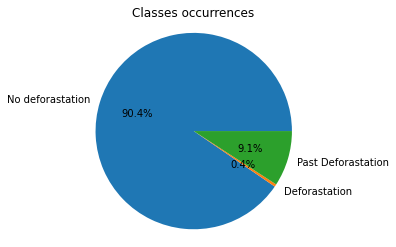

In [18]:
Tasks = counts

my_labels = 'No deforastation','Deforastation','Past Deforastation'
fig = plt.figure()
plt.pie(Tasks,labels=my_labels, autopct='%1.1f%%')
plt.title('Classes occurrences')
plt.axis('equal')
plt.show()
# fig.savefig('/media/thimabru/ssd/TCC/classes_occurrences.jpg', dpi=300)

In [18]:
def extract_patches(image, reference, patch_size, stride):
    window_shape = patch_size
    window_shape_array = (window_shape, window_shape, image.shape[2])
    window_shape_ref = (window_shape, window_shape)
    patches_array = np.array(view_as_windows(image,
                                             window_shape_array, step=stride))

    patches_ref = np.array(view_as_windows(reference,
                                           window_shape_ref, step=stride))

    print('Patches extraidos')
    # print(patches_array.shape)
    num_row, num_col, p, row, col, depth = patches_array.shape

    # print('fazendo reshape')
    #check_memory()
    del image, reference
    #check_memory()
    patches_array = patches_array.reshape(num_row*num_col, row, col, depth)
    # print(patches_array.shape)
    patches_ref = patches_ref.reshape(num_row*num_col, row, col)
    # print(patches_ref.shape)

    return patches_array, patches_ref

In [20]:
def normalization(image, norm_type=1):
    image_reshaped = image.reshape((image.shape[0] * image.shape[1]),
                                   image.shape[2])
    if(norm_type == 1):
        scaler = StandardScaler()
    if(norm_type == 2):
        scaler = MinMaxScaler(feature_range=(0, 1))
    if(norm_type == 3):
        scaler = MinMaxScaler(feature_range=(-1, 1))
    # scaler = scaler.fit(image_reshaped)
    print(scaler.get_params())
    # print(scaler.mean_)
    image_normalized = scaler.fit_transform(image_reshaped)
    image_normalized1 = image_normalized.reshape(image.shape[0],image.shape[1],image.shape[2])
    return scaler, image_normalized1

In [21]:
# scaler, input_image = normalization(input_image, norm_type=1)

{'copy': True, 'with_mean': True, 'with_std': True}


/home/thimabru/.virtualenvs/base/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype uint16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [19]:
patch_size = 128
stride = 128
patches_img, patches_ref = extract_patches(input_image, final_mask, patch_size,
                                            stride)

Patches extraidos


In [20]:
print(len(patches_img))

1560


In [52]:
aug = A.RandomRotate90(p=1)

In [42]:
aug = A.ElasticTransform(p=1, alpha=60, sigma=60 * 0.05, alpha_affine=60 * 0.03)
# aug = A.GridDistortion(p=1)
random.seed(7)

In [50]:
aug = A.RandomSizedCrop(min_max_height=(60, 100), height=128, width=128, p=1)

random.seed(7)

(128, 128, 3)
(128, 128)


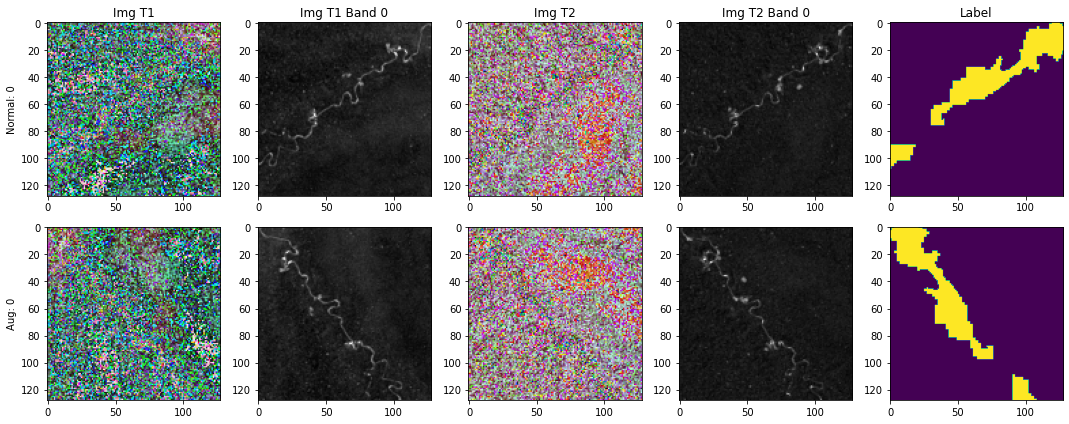



(128, 128, 3)
(128, 128)


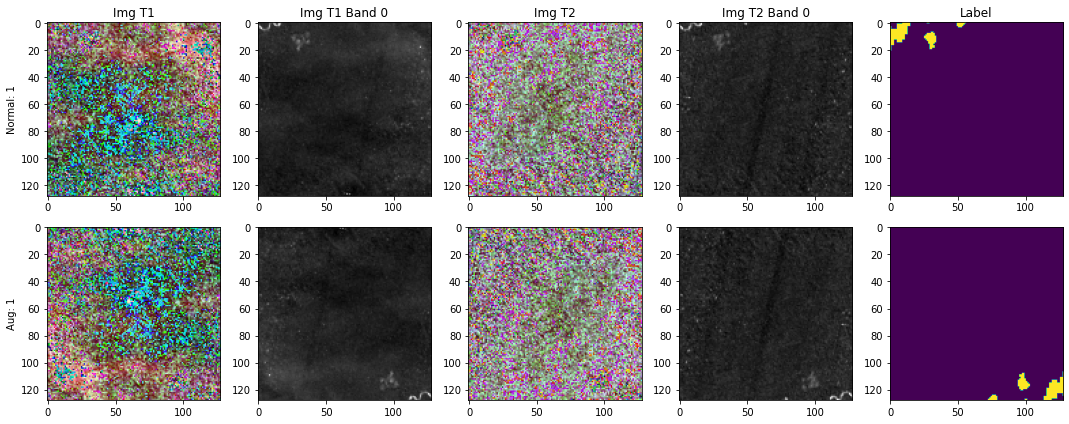



(128, 128, 3)
(128, 128)


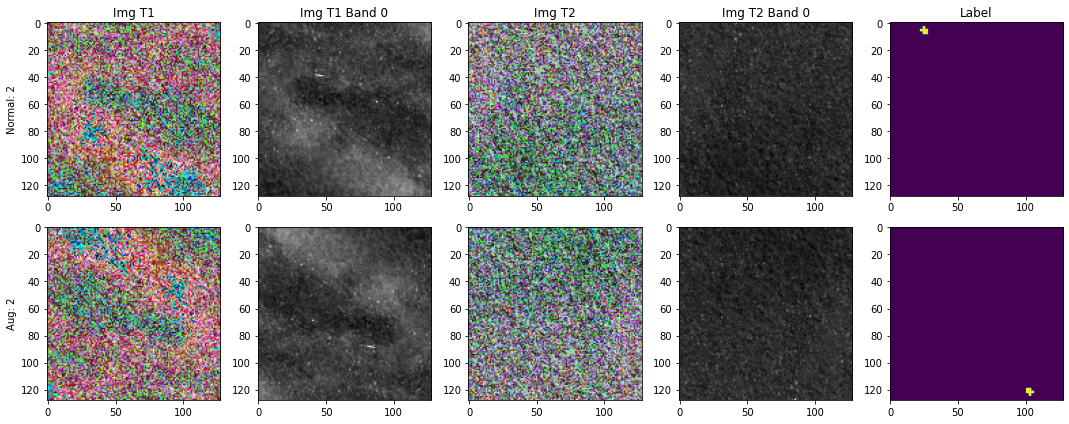



(128, 128, 3)
(128, 128)


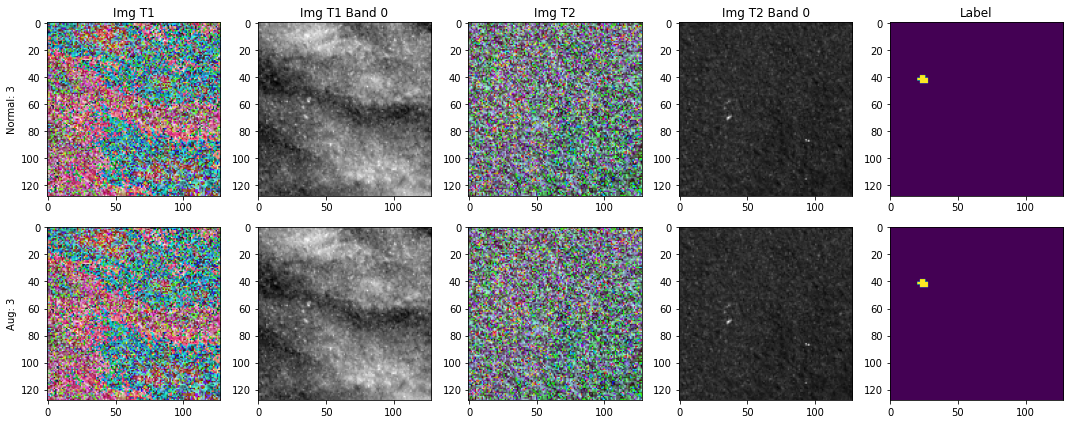



(128, 128, 3)
(128, 128)


KeyboardInterrupt: 

In [55]:
for i in range(len(patches_img)):
    img = patches_img[i]
    img_ref = patches_ref[i]
#     print(img_ref.shape)
    
    img_ref_h = tf.keras.utils.to_categorical(img_ref, 3)
    print(img_ref_h.shape)
    test_img_ref_h = np.concatenate((img_ref_h, img_ref_h, img_ref_h, img), axis=-1)
    augmented = aug(image=img, mask=img_ref_h)
    
    image_rot90 = augmented['image']
#     print(image_rot90.shape)
    mask_rot90 = augmented['mask']
    mask_rot90 = np.argmax(mask_rot90[:, :, 0:3], axis=-1)
    
    
    # img_trans = scaler.inverse_transform(img)
    img_trans = img
    
    img_t1_patch = img_trans[:, :, 0:7]
    img_t2_patch = img_trans[:, :, 7:]
    img_t1_bgr_patch = img_t1_patch[:, :, 1:4].astype(np.uint8)
    img_t1_rgb_patch = img_t1_bgr_patch[:, :, ::-1]
    img_t2_bgr_patch = img_t2_patch[:, :, 1:4].astype(np.uint8)
    img_t2_rgb_patch = img_t2_bgr_patch[:, :, ::-1]
    
    
    fig2, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 6))
    plt.subplots_adjust(hspace=0, wspace=0)
    axes[0, 0].set_ylabel(f'Normal: {i}')
    col = 0
    axes[0, col].set_title('Img T1')
    axes[0, col].imshow(img_t1_bgr_patch)
    col = 1
    axes[0, col].set_title('Img T1 Band 0')
    axes[0, col].imshow(img_t1_patch[:, :, 0], cmap='gray')
    col = 2
    axes[0, col].set_title('Img T2')
    axes[0, col].imshow(img_t2_bgr_patch)
    col = 3
    axes[0, col].set_title('Img T2 Band 0')
    axes[0, col].imshow(img_t2_patch[:, :, 0], cmap='gray')
    col = 4
    axes[0, col].set_title('Label')
    axes[0, col].imshow(img_ref)
    
    # Aug -----------------------------------------------------------
    axes[1, 0].set_ylabel(f'Aug: {i}')
    img_trans = image_rot90
    
    img_t1_patch = img_trans[:, :, 0:7]
    img_t2_patch = img_trans[:, :, 7:]
    img_t1_bgr_patch = img_t1_patch[:, :, 1:4].astype(np.uint8)
    img_t1_rgb_patch = img_t1_bgr_patch[:, :, ::-1]
    img_t2_bgr_patch = img_t2_patch[:, :, 1:4].astype(np.uint8)
    img_t2_rgb_patch = img_t2_bgr_patch[:, :, ::-1]
    

    col = 0
    axes[1, col].imshow(img_t1_bgr_patch)
    col = 1
    axes[1, col].imshow(img_t1_patch[:, :, 0], cmap='gray')
    col = 2
    axes[1, col].imshow(img_t2_bgr_patch)
    col = 3
    axes[1, col].imshow(img_t2_patch[:, :, 0], cmap='gray')
    col = 4
    print(mask_rot90.shape)
    axes[1, col].imshow(mask_rot90)
    
    

    plt.tight_layout()
    plt.show()
    plt.close()
    print()
    print()